<a href="https://colab.research.google.com/github/MinahilRaza/Bayesian-Inference-Criteria-based-Clustering/blob/main/ClusteringAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Analysis
The method consists of three steps:
1. Building the correlation matrices from the Z-score table
2. Ordering the correlation matrices using simulated annealing
3. Identifying the clusters based on the lowest BIC score


Upload the Z-score table as a CSV file

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving input_data.csv to input_data.csv


In [ ]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from copy import deepcopy

In [ ]:
# set random seeds
random.seed(0)
np.random.seed(0)

## Building the Correlation Matrix
The Z-score table T is RxC matrix with R rows and C columns. First, we calculate the correlation matrix for rows and columns. Let's consider the correlation matrix A for the rows. It is an RxR matrix. Let each row be a vector, then for R rows, we calculate a cosine similarity value with each row.
$$A_{ij} = \frac{\vec{R_i} \cdot \vec{Rj}}{\left | \vec{R_i} \right |\left | \vec{R_j} \right |}$$

In [ ]:
def CreateSimilarityMatrix(X: np.ndarray, direction = 'row'):
    '''
    Returns the correlation matrix for rows or columns from a zscore table.

    Parameters:
        X (np.ndarray): The zscore table.
        direction (str): 'row' for row-wise similarity matrix
                         'col' for column-wise similarity matrix

    Returns:
        The correlation matrix for dpecified direction.   
    '''  

    if direction == 'col':
      X = X.T
    elif direction != 'row':
      print("Incorrect value for direction. Can be \'row\' or \'col\'")
    
    matrix = np.dot(X,X.T)
    # Calculate arrays with magnitudes of vectors
    p1 = np.linalg.norm(X, axis = 1, keepdims = True)
    p2 = p1.T
    # Normalize to find cosine
    matrix = matrix/(p1*p2)

    return matrix

In [ ]:
def RandomizeOrder(n:int):
   '''
    Returns the randomized kernel order

    Parameters:
        n (int): size of kernel orders.

    Returns:
        The randomized kernel order.   
    '''
   order = [i for i in range(0,n)]
   random.shuffle(order)
   return order

In [ ]:
def gauss(variance):
  '''
    Draw random samples from a normal (Gaussian) distribution.

    Parameters:
        variance (float): variance of Gaussian distribution

    Returns:
        a random sample from the Gaussian distribution   
    '''  
  return np.random.normal(scale = np.sqrt(variance)) 

def MakeChangeVectors(order, line1, line2, width, n, klines):
  '''
    Returns the lists of nodes that are changed and not changed in the new ordering.

    Parameters:
        order (list): The current kernel order.
        line1, line2 (int): to indicate boundary of kernel rows which would be reordered
        width (int): width of segment to be reordered
        n (int): size of similarity matrix
        klines (list): list of nodes within kernels

    Returns:
        - list of nodes whose position has been changed.
        - list of nodes whose position has not been changed
    '''  
  change = []
  nochange= []
  nk = len(klines)
  line1 = int(line1)
  line2 = int(line2)
  for i in range(0, width):
    in1 = order[line1 + i]
    jmax = n - klines[in1]
    if (in1 != nk - 1):
      jmax = klines[in1+1] - klines[in1]
    for j in range(0, jmax):
      change.append(klines[in1] + j)
  if line1 < line2:
    upper = line2 + width
    lower = line1 + width
  if line1 >= line2:
    upper = line1
    lower = line2
  for i in range(lower, upper):
    in1 = order[i]
    jmax = n-klines[in1];
    if in1 != nk-1:  
      jmax = klines[in1+1] - klines[in1];
    for j in range(0, jmax):
      change.append(klines[in1] + j)
  nochange = set(range(0,n))-set(change)
  nochange = list(nochange)
  return change, nochange

def ChangeSegmentOrder(order,line1,line2,width):
   '''
    Returns the changed order of kernel rows within the selected segment.

    Parameters:
        order (list): The current kernel order.
        line1, line2 (int): to indicate boundary of kernel rows which would be reordered
        width (int): width of segment to be reordered

    Returns:
        changed segment order
    '''
   pos = [order[line1 + i] for i in range(0, width)]
   line1 = int(line1)
   line2 = int(line2)
   if line1 < line2:
    j = 0
    for i in range(line1 + width, line2 + width):
      order[line1 + j] = order[i]
      j = j+1
    for i in range(0, width):
      order[line2 + i] = pos[i]
   if line1 > line2:
    for i in range(line1-1, line2-1, -1):
      order[i + width] = order[i]
    for i in range(0, width):
      order[line2 + i] = pos[i]
   return order

def EnergyChangeReOrd(mat, l1, l2, w, n, kernelOrder, klines):
  '''
    Returns the change in energy between the old and new orders

    Parameters:
        mat (np.ndarray): similarity matrix to be reordered
        kernelOrder (list): The current kernel order.
        l1, l2 (int): to indicate boundary of kernel rows which would be reordered
        width (int): width of segment to be reordered
        n (int): size of similarity matrix
        klines (list): list of nodes within kernels

    Returns:
        change in energy
    '''
  deltaen = 0
  lchange, lfix = MakeChangeVectors(kernelOrder, l1, l2, w, n, klines)
  oldorder = GetNodeOrder(kernelOrder, klines, n, 0)
  newKernelOrder=kernelOrder
  newKernelOrder = ChangeSegmentOrder(newKernelOrder,l1,l2,w)
  newOrder = GetNodeOrder(newKernelOrder, klines, n, 0)
  for line1 in lchange:
    for line2 in lfix:
      deltaen = deltaen + 2*mat[line2][line1]* (np.abs(newOrder[line1]- newOrder[line2])-
                                       np.abs(oldorder[line1]-oldorder[line2]))/n
  x = len(lchange) -1
  for i in range(0, x):
      for j in range(i + 1 ,len(lchange)):
        line1 = lchange[i]
        line2 = lchange[j]
        deltaen = deltaen + 2*mat[line2][line1]* (np.abs(newOrder[line1]- newOrder[line2])-
                                       np.abs(oldorder[line1]-oldorder[line2]))/n
  return deltaen

def AnnealStep(temperature, matrix, netSize, order, nblocks, klines):
  '''
    Performs one step in annealing. Returns the changed order and change in energy

    Parameters:
        temperature (int): temperature for annealing  step
        matrix (np.ndarray): the similarity matrix
        order (list): The current kernel order.
        netSize (int): size of similarity matrix
        line1, line2 (int): to indicate boundary of kernel rows which would be reordered
        nblocks (int): number of blocks        
        klines (list): list of nodes within kernels

    Returns:
        -new kernel order
        -change in energy
    '''
  nkernels = len(klines)
 
  width = int(np.fabs(gauss(np.sqrt(temperature)*0.05*nkernels))) + nblocks
  width = width- (width%nblocks)
  line1 = int( (nkernels-width)*np.random.uniform())
  line1 = line1 - line1%nblocks
  line1 = np.max([line1, 0])
  while( width > nkernels-line1 ):
    width = int(np.fabs(gauss(np.sqrt(temperature)*0.05*nkernels))) + nblocks
    width = width- (width%nblocks)
  line2 = int(gauss(np.sqrt(temperature)*0.1))
  if line2<0:
    line2= line2 - line1
    line2 = np.max([line2, 0])
  else:
    line2 = line2 + line1 + width
    line2 = np.min([line2, nkernels-width] )
  line2 = line2 - (line2%nblocks)
  deltaE=  EnergyChangeReOrd( matrix, line1, line2, width, netSize, deepcopy(order), klines)
  if temperature == 0:
    prob = 0
  else:
    prob = np.exp( -deltaE/temperature )
  if np.random.uniform() < prob:
    order = ChangeSegmentOrder(order, line1, line2, width);
    return deltaE, order
  return 0, order

In [ ]:
def GetNodeOrder(kernelOrder, klines, netSize:int, option: int):
  '''
    Returns the node order.

    Parameters:
        kernelOrder (list): The current kernel order.
        klines (list): list of nodes within kernels
        netSize (int): size of similarity matrix
        option (int): choose which nodeOrder to return
            - option == 0: nodeOrder[originalposition]=currentposition
            - option == 1: nodeOrder[currentposition]=originalposition
    Returns:
        - nodeOrder: list of nodes
    '''
  nodeOrder = np.zeros((netSize))
  if option == 0:
    k = 0
    for i in kernelOrder:
      jmax = netSize-klines[i]
      if i!=len(kernelOrder)-1:
        jmax=klines[i+1]-klines[i]
      
      for j in range(0, jmax):
        nodeOrder[klines[i]+j]=k
        k = k + 1
  if option == 1:
    k = 0;
    for i in kernelOrder:
      jmax = netSize-klines[i]
      if i!=len(kernelOrder)-1:
        jmax=klines[i+1]-klines[i]

      for j in range(0, jmax):
        nodeOrder[k]=klines[i]+j
        k = k + 1
  return nodeOrder

In [ ]:
def ComputeEnergy(mat, netSize, kernelOrder, klines):
  '''
    Returns the energy of current order of the similarity matrix

    Parameters:
        mat (np.ndarray): similarity matrix
        netSize (int): size of similarity matrix
        kernelOrder (list): The current kernel order.
        klines (list): list of nodes within kernels

    Returns:
        - energy of the matrix
    '''
  energy = 0.0
  nodeOrder = GetNodeOrder(kernelOrder, klines, netSize, 1 )
  for i in range(0, netSize-1):
    for j in range(i+1, netSize):
      a = int(nodeOrder[i])
      b = int(nodeOrder[j])
      energy = energy + 2*np.abs(i-j)*mat[b][a]/netSize
  return energy

In [ ]:
def GetKernels(similarityMatrix:np.ndarray, n:int, translationTable:list):
  '''
    Rearranges similarity matrix and finds kernel.

    Parameters:
        similarityMatrix (np.ndarray): The similarity matrix (row or col wise).
        n (int): dimensions of similarityMatrix are n*n
        translationTable (list): the initial translation table            

    Returns:
        similarityMatrixNew: The new similarity matrix 
        kernelOrder: The order of kernels
        kkline: list of lines at which each kernel starts
        n: dimension of similarity matrix
        translationTableNew: the new translation table
        kernelList: The list of nodes inside each kernel
   
    '''  
  nn = n
  kernelsize = []
  knodelist = []
  kernelList = [] # list of nodes inside each kernel
  kernelOrder = [] # order of kernels
  kkline = [] # list of lines at which each kernel starts
  assignedNodes = [] # previously assigned nodes
  translationTableNew = []
  nodeCount = 0
  kernelCount = 0
  
  for i in range(0, nn):
    if i not in assignedNodes:
      knodelist.append(nodeCount)
      kkline.append(nodeCount)
      kernelOrder.append(kernelCount)
      assignedNodes.append(i)
      translationTableNew.append(translationTable[i])
      nodeCount =  nodeCount + 1
      for j in range(i+1, nn):
        if similarityMatrix[j][i] == 1:
          knodelist.append(nodeCount)
          assignedNodes.append(j)
          translationTableNew.append(translationTable[j])
          nodeCount =  nodeCount + 1
      kernelCount = kernelCount + 1
      kernelList.append(knodelist)
      kernelsize.append(len(knodelist))
      knodelist = [] # clear list
  nn = len(assignedNodes)
  similarityMatrixNew = np.zeros((nn,nn))
  for i in range(0, len(assignedNodes)):
    for j in range(i, len(assignedNodes)):
      similarityMatrixNew[i][j] = similarityMatrix[assignedNodes[j]][assignedNodes[i]]
      similarityMatrixNew[j][i] = similarityMatrix[assignedNodes[j]][assignedNodes[i]]
  
  n = len(kernelList)
  return similarityMatrixNew, kernelOrder, kkline, n, translationTableNew, kernelList


In [ ]:
def AnnealIter(temperature: float, matrix, nsteps, n, order, energy, nblocks, kline):
  '''
    Performs one iteration of simulated annealing

    Parameters:
        temperatur (float): starting temperature of the annealing process
        matrix (np.ndarray): similarity matrix
        nsteps (int): number of steps within one iteration
        n (int): size of similarity matrix
        order (list): The current kernel order.
        energy (int): initial energy of the matrix
        nblock (int): number of blocks
        kline (list): list of nodes within kernels

    Returns:
        - changed kernelOrder
        - energy of the matrix
    '''
  for step in range(0, nsteps):
    deltaen, order =  AnnealStep(temperature, matrix, n, order, nblocks, kline)
    energy = energy + deltaen
  return order, energy

In [ ]:
def OrderKernel(similarityMatrix,randomization, T, factor):
  '''
    Performs simulated annealing to reorder the matrix
    
    Parameters:
        similarityMatrix (np.ndarray): similarity matrix to be reordered
        randomization (int): specifies whether the matrix be reordered initially to a random order
        T (float): startign temperature of annealing process
        factor (float): factor by which the temperature should be changed

    Returns:
        - new kernel order
        - reordered matrix
    '''
  EPS = 0.00000001
  n = similarityMatrix.shape[0]
  translationTable = [i for i in range(0, n)]
  similarityMatrix, kernelOrder, klines, nkernels, translationTable,\
      kernels = GetKernels(similarityMatrix, n, translationTable)
  if randomization == 1:
    kernelOrder  = RandomizeOrder(n)
  energyold = ComputeEnergy(similarityMatrix, n, kernelOrder, klines)
  energy = energyold
  count = 0
  nblocks = 1
  # atleast perform 10 steps
  Nsteps = np.max([int(0.01*(nkernels/nblocks)**2), 10])
  iter = 0
  if nkernels >2:
    while count<20:
      kernelOrder, energy = AnnealIter(T,similarityMatrix, Nsteps, n, kernelOrder, energy, nblocks, klines)
      if np.fabs( energyold - energy ) < EPS: 
          count = count + 1
          
      else:
        count = 0
      energyold = energy
      T = T* factor
      iter = iter + 1
  sim = np.zeros((n,n))
  nodeOrder = GetNodeOrder( kernelOrder, klines, n, 1)
  for i in range(0, n):
    i1 = int(nodeOrder[i])
    for j in range(0,n):
      j1 = int(nodeOrder[j])
      sim[i][j] = similarityMatrix[j1][i1]
  return kernelOrder, sim

In [ ]:
def VisualizeClusters(unordered_mat, ordered_mat, labels, kernelOrder, partition, save, filename):
  # Function to make plots
  
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
  sns.heatmap(unordered_mat, cmap= 'YlOrRd', ax=ax1, vmin=-1, vmax=1)
  ax1.set_title('Unordered Matrix')
  ax1.set_xticks(np.arange(len(labels))+0.5)
  ax1.set_xticklabels(labels, rotation = 90)
  ax1.set_yticks(np.arange(len(labels))+0.5)
  ax1.set_yticklabels(labels, rotation = 0)

  sns.heatmap(ordered_mat, cmap= 'YlOrRd', ax=ax2, vmin=-1, vmax=1)
  ax2.set_title('Ordered Matrix')
  ax2.set_xticks(np.arange(len(labels))+0.5)
  ax2.set_xticklabels(labels[kernelOrder], rotation = 90)
  ax2.set_yticks(np.arange(len(labels))+0.5)
  ax2.set_yticklabels(labels[kernelOrder], rotation =0)

  # plot cluster boundaries
  for part in partition:
    ax2.add_patch(
      patches.Rectangle(
          (part[0], part[0]),
          part[1]-part[0]+1,
          part[1]-part[0]+1,
          edgecolor='black',
          fill=False,
          lw=4
      ) )

  fig.tight_layout()
  if save:
    plt.savefig(filename,dpi=200)
    df = pd.DataFrame(ordered_mat, labels[kernelOrder], columns=labels[kernelOrder])
    df.to_excel(filename.replace('.png', '.xlsx'))
  plt.show()

In [ ]:
def GetKernelRows(similarityMatrix, netSize):
    '''
    Returns the kernel rows within the similarity matrix

    Parameters:
        similarityMatrix (np.ndarray): similarity matrix
        netSize (int): size of similarity matrix
        
    Returns:
        - list: kernelRows within the similarity matrix
    '''
    kernelRows = [0]
    nrow = 0
    for row in range(0, netSize):
     for col in range(row+1, netSize):
      row = col
      if similarityMatrix[col][nrow]!=1:
        kernelRows.append(col)
        nrow = col
        break
    return kernelRows

In [ ]:
def InitializePartition(nbox, netSize):
  '''
    Returns the initial partition

    Parameters:
        nbox (int): number of boxes to initialize
        netSize (int): size of similarity matrix

    Returns:
        - partition within the similarity matrix
    '''
  partition = []
  tempPart = [0]
  node = 0
  for i in range(0,nbox-1):
    node += int((netSize - nbox + i - node)* np.random.uniform())
    tempPart.append(node)
    partition.append(tempPart)
    node = node + 1
    tempPart = [node]
  tempPart.append(netSize-1)
  partition.append(tempPart)
  return partition

In [ ]:
def AddPartition(partition, nPart, kernel):
  '''
    Returns the new partition

    Parameters:
        partition (list): current partition
        nPart (int): indicates where the partition exists
        kernel: kernel where the boundary of partition lies

    Returns:
        - new partition within the similarity matrix
    '''
  partitionnew = []
  for  j in range(0, len(partition)):
    if j== nPart:
      partitionnew.append([partition[j][0], kernel])
      partitionnew.append([kernel+1, partition[j][1]])
    else:
      partitionnew.append(partition[j])
  return partitionnew


In [ ]:
def ComputeLeastSquares(similarityMatrix, partition, netSize, kernelRows):
  '''
    Computes least squares for partitioning

    Parameters:
        similarityMatrix (np.ndarray): The similarity matrix
        partition (list): partitions within the similarity matrix
        netSize (int): size of similarity matrix
        kernelRows (list): list of kernel rows within the similarity matrix

    Returns:
        mean, count and average least squares values
    '''
  numberBoxes = len(partition)
  leastSquares = 0
  boxAverage=0
  boxAverageSq=0
  outAverage=0
  outAverageSq=0
  AverageTotal=0
  AverageSqTotal=0
  inCount=0
  outCount=0
  totalCount = 0
  tempMean = []
  tempCount = []
  for j in range(0, numberBoxes):
    inCount=0
    boxAverage=0
    boxAverageSq=0
    for i in range(partition[j][0], partition[j][1]+1):
      row = kernelRows[i]
      nodesInKerneli = netSize - row
      if i< len(kernelRows)-1:
        nodesInKerneli = kernelRows[i+1] - row
      inCount = inCount + nodesInKerneli * (nodesInKerneli + 1)/2
      boxAverage = boxAverage+ similarityMatrix[row][row]*nodesInKerneli*(nodesInKerneli + 1)/2
      boxAverageSq = boxAverageSq+ similarityMatrix[row][row]*similarityMatrix[row][row]*nodesInKerneli*(nodesInKerneli + 1)/2
      for k in range(i+1, len(kernelRows)):
        col = kernelRows[k]
        nodesInKernelk = netSize - col
        if k< len(kernelRows)-1:
          nodesInKernelk = kernelRows[k+1] - col
        if k<= partition[j][1]:
          inCount = inCount + nodesInKerneli* nodesInKernelk
          boxAverage = boxAverage+ similarityMatrix[col][row]*nodesInKerneli*nodesInKernelk
          boxAverageSq = boxAverageSq+ similarityMatrix[col][row]*similarityMatrix[col][row]*nodesInKerneli*nodesInKernelk
          
        else:
          outCount = outCount + nodesInKerneli* nodesInKernelk
          outAverage = outAverage + similarityMatrix[col][row] *nodesInKerneli * nodesInKernelk
          outAverageSq = outAverageSq + similarityMatrix[col][row]**2 *nodesInKerneli * nodesInKernelk
    

    tempMean.append(boxAverage)
    tempCount.append(inCount)
    totalCount = totalCount + inCount
    AverageSqTotal = AverageSqTotal + boxAverageSq
    if inCount>0:
       AverageTotal =  AverageTotal + boxAverage**2/inCount
  tempMean.append(outAverage)
  tempCount.append(outCount)
  if outCount>0:
       AverageSqTotal = AverageSqTotal + outAverageSq
       AverageTotal =  AverageTotal + outAverage**2/outCount
  leastSquares = AverageSqTotal - AverageTotal
  totalCount = totalCount + outCount
  
  return tempMean, tempCount, leastSquares/ totalCount



In [ ]:
def ComputeDeltaLeastSq(netSize, width, box, neig, meanChange, mean, count, boxSize1, boxSize2):
  '''
    Returns the change in least squares value.
  '''
  deltaEn = 0
  nbox1p = count[box] - width*(2*boxSize1 - width + 1)/2
  nbox2p = count[box+neig] + width*(2*boxSize2 + width + 1)/2
  nboxop = count[-1] - (width*(boxSize2 - boxSize1 + width))
  deltaMeanBox1 = 0
  if nbox1p >0:
    deltaMeanBox1 = deltaMeanBox1 + (mean[box]+meanChange[0])*(mean[box]+meanChange[0])/nbox1p
  if count[box]>0:
    deltaMeanBox1 =  deltaMeanBox1 - mean[box]*mean[box]/count[box]
  deltaMeanBox2 = 0
  if nbox2p >0:
    deltaMeanBox2 = deltaMeanBox2 + (mean[box+neig]+meanChange[1])*(mean[box+neig]+meanChange[1])/nbox2p
  if count[box+neig]>0:
    deltaMeanBox2 = deltaMeanBox2 - mean[box+neig]*mean[box+neig]/count[box+neig]
  deltaMeanOut= 0
  if nboxop >0:
    deltaMeanOut = deltaMeanOut + (mean[-1]+meanChange[2])*(mean[-1]+meanChange[2])/nboxop
  if count[len(count)-1] > 0:
    deltaMeanOut = deltaMeanOut - mean[-1]*mean[-1]/count[-1]
  deltaMean1 = -deltaMeanBox1
  deltaMean2 = -deltaMeanBox2
  deltaOut = -deltaMeanOut
  deltaEn = deltaMean1 + deltaMean2 + deltaOut
  return 2*deltaEn / (netSize*netSize+netSize)

In [ ]:
def ComputeChanges(simMat, kernelChange, kernelStay1, kernelStay2, netSize, kernelRows):
  '''
    Function that computes the changes in mean, when changing the breaking point
  '''
  average = 0 
  deltaLeastSq = 0
  avv = 0  
  for i in range(kernelChange[0], kernelChange[1]+1):
    row =  kernelRows[i]
    nodesInKerneli = netSize - row
    if i < len(kernelRows)-1:
      nodesInKerneli = kernelRows[i+1] - row
    average = average + simMat[row][row] * nodesInKerneli* (nodesInKerneli + 1)/2
    avv = avv + simMat[row][row] * nodesInKerneli* (nodesInKerneli +1)/2  
    for j in range(i+1, kernelChange[1]+1):
      col = kernelRows[j]
      nodesInKernelj = netSize - col
      if (j < len(kernelRows)-1):
        nodesInKernelj = kernelRows[j+1]-kernelRows[j];
      average = average +  simMat[col][row]	* nodesInKerneli* nodesInKernelj
      avv = avv + simMat[col][row]* nodesInKerneli* nodesInKernelj
    for j in range(kernelStay1[0], kernelStay1[1]+1):
      col = kernelRows[j]
      nodesInKernelj = netSize - col
      if (j < len(kernelRows)-1):
        nodesInKernelj = kernelRows[j+1]-kernelRows[j];
      average = average +  simMat[col][row]	* nodesInKerneli* nodesInKernelj
    for j in range(kernelStay2[0], kernelStay2[1]+1):
      col = kernelRows[j]
      nodesInKernelj = netSize - col
      if (j < len(kernelRows)-1):
        nodesInKernelj = kernelRows[j+1]-kernelRows[j];
      avv = avv +  simMat[col][row]	* nodesInKerneli* nodesInKernelj
  return [-average, avv, average-avv]
      

In [ ]:
def GetCount(kernelIni, kernelEnd, kernelRows, netSize):
  '''
    Function that returns the lateral size of a box with kernels form kerenlIni to kernelEnd
    '''
  nodeCount = 0
  for kernel in range(kernelIni, kernelEnd+1):
    kernelSize = netSize - kernelRows[kernel]
    if kernel < len(kernelRows) -1:
      kernelSize = kernelRows[kernel +1 ] - kernelRows[kernel]
    nodeCount = nodeCount + kernelSize
  return nodeCount

In [ ]:
def UpdatePartition( width, box, neig, partition, mean, meanChange, count, kernelRows, netSize):
  '''
    Updates the current partition
    '''
  nBox1 = GetCount(partition[box][0],partition[box][1], kernelRows, netSize )
  nBox2 = GetCount(partition[box+neig][0],partition[box+neig][1], kernelRows, netSize )

  nbox1p = count[box] - width*(2*nBox1 - width + 1)/2
  nbox2p = count[box+neig] + width*(2*nBox2 + width + 1)/2
  nboxop = count[-1] - (width*(nBox2 - nBox1 + width))
  kernelWidth = 1
  if neig == 1:
    partition[box][1] = partition[box][0]-kernelWidth
    partition[box+neig][0] = partition[box][1]+1
  if neig == -1:
    partition[box+neig][1] = partition[box][0]+kernelWidth-1
    partition[box][0] = partition[box][0]+kernelWidth
  mean[box] = mean[box]+ meanChange[0]
  mean[box+neig] = mean[box+neig]+ meanChange[1]
  mean[-1] = mean[-1]+ meanChange[2]

  count[box] = nbox1p
  count[box+neig] = nbox2p
  count[-1] = nboxop

In [ ]:
def GetAnyBestSplit(partition, nPart, similarityMatrix, netSize, leastSqOld, leastSqMin, kernelRows):
  '''
    Function that finds the best split inside a box, regaaardless of whether the least Squares in minimized with respect
    to the partition with one box less or not. Breaking points are considered to be between kernels.
  '''
  kernelChange = []
  kernelStay1 = []
  kernelStay2 = []
  partitionOld =partitionTemp = AddPartition(partition, nPart, partition[nPart][0])
  mean, count, leastSq = ComputeLeastSquares(similarityMatrix, partitionTemp, netSize, kernelRows)
  nodeMin = partition[nPart][0]
  leastSqMin = leastSq
  for j in range(partition[nPart][0]+1,partition[nPart][1]):
    kernelChange = []
    kernelStay1 = []
    kernelStay2 = []
    kernelStay1.append(j+1)
    kernelStay1.append(partition[nPart][1])
    kernelStay2.append(partition[nPart][0])
    kernelStay2.append(j-1)
    kernelChange.append(j)
    kernelChange.append(j)
    meanChange = ComputeChanges(similarityMatrix, kernelChange, kernelStay1, kernelStay2, netSize, kernelRows)
    nBox1 = GetCount(partition[nPart][0], j-1, kernelRows, netSize)
    nBox2 = GetCount(j, partition[nPart][1], kernelRows, netSize)
    width = kernelRows[j+1] - kernelRows[j]
    deltaLeastSq = ComputeDeltaLeastSq(netSize, width, nPart+1, -1, meanChange,
			      mean, count, nBox2, nBox1 )
    UpdatePartition( width, nPart+1, -1, partitionOld, mean,
		     meanChange, count, kernelRows, netSize)
    leastSq = leastSq + deltaLeastSq
    if leastSq < leastSqMin - 1e-8:
      leastSqMin = leastSq
      nodeMin=j
  result = [1, nodeMin, nodeMin]
  return result, leastSqMin

In [ ]:
def SplitPartitionAlways(partition, label, simMatrix, netSize, leastSqOld, kernelRows):
  '''
    Finds the best split for a certain number of boxes. The labels vector keeps track of which is the box that was
    split (1)
    '''
  splitResult = []
  nSplit = -1
  leastSq = 10000
  leastSqMin = 0
  labelNew = []
  partitionNew = []
  for i in range(0, len(partition)):
    result, leastSqMin = GetAnyBestSplit(partition, i, simMatrix, netSize, leastSqOld, leastSqMin, kernelRows)
    splitResult.append(result)
    if partition[i][1]!= partition[i][0]:
      if leastSqMin < leastSq -1e-8:
        nSplit = i
        leastSq = leastSqMin
  for i in range(0, len(partition)):
    if i== nSplit:
      labelNew.append(1)
      partitionNew.append([partition[i][0], splitResult[i][1]])
      partitionNew.append([splitResult[i][1]+1, partition[i][1]])
      labelNew.append(1)
    else:
      partitionNew.append(partition[i])
      labelNew.append(0)

  if nSplit != -1:
    leastSquares = ComputeLeastSquares(simMatrix, partitionNew, netSize, kernelRows)
    leastSqOld = leastSq
  return partitionNew, labelNew, leastSq


In [ ]:
def FindOptimalPartition(partition, label, simMatrix, netSize, leastSqOld, partHist, leastSqHist, nBox, kernelRows):
  '''
    Finds optimal partition using greedy algorithm The algorithm will try to find iteratively the best partition with 
    two boxes by evaluation of leastSq(2) for each breaking point bPoint, and selecting the bPoint for which leastSq is
    minimal.  Then, the algorithm will add another breaking point, if it finds a partition for which 
    leastSq(3)<leastSq(2). It will iterate the process until it cannot find a better partition.  The function also 
    stores the history of the best partition found for each number of boxes
  '''
  min = len(kernelRows)-1
  min = np.min([min,nBox])
  while len(partition)<min:
    partition, label, leastSqOld = SplitPartitionAlways( partition, label, simMatrix, netSize, leastSqOld, kernelRows)
    leastSqHist.append(leastSqOld)
    partHist.append(partition)


In [ ]:
def GetBIC(L, n, kp):
  '''
    Returns the Bayesian Information Criterion

    Parameters:
       L (float): sum of residual squares
       n (int): number of data points
       k (int): number of parameters

    Returns:
        - BIC score
    '''
  k = 2 * kp + 1
  return n * np.log(L) + k * np.log( n )

def GetBestPartitionBIC(leastSq,  partitionHist, lSqHist,n):
  '''
    Gets the best partition for partitionHistory according to the Bayesian information criterion

    Parameters:
        leastSq (float): The least squares values of current partition
        partitionHist(list): partition history for current execution of algorithm
        lSqHist(list): least square values for each partition in partitionHist
        n (int): size of similarity matrix

    Returns:
        - best partition according to BIC score
    '''
  part = -1
  min = 10000
  max = 0
  for i in range(0, len(lSqHist)):
    bic = GetBIC(lSqHist[i], n, len(partitionHist[i]))
    if bic<min:
      min = bic
      part = i
    max = np.max([bic, max])
  if part != -1:
    return partitionHist[part]
  return partitionHist[-1]

In [ ]:
def FindBestPartitionBIC(sim, n):
  '''
    Returns the best partition according to BIC score (greedy approach)

    Parameters:
        sim (np.ndarray): The similarity matrix
        n (int): size of similarity matrix

    Returns:
        - best partition according to the BIC score
    '''
  average = np.append(sim, np.ones((n,1)), axis=1).mean()
  variance = (np.append(sim, np.ones((n,1)), axis=1)**2).mean()
  kernelRows = GetKernelRows(sim, n)
  partition = InitializePartition(1, n)
  label = []
  leastSqOld = 0
  leastSqHist=[]
  leastSq = 0
  partitionHist = []
  FindOptimalPartition(partition, label, sim, n, leastSqOld, partitionHist, leastSqHist,10, kernelRows)
  partition = GetBestPartitionBIC(leastSq, partitionHist, leastSqHist, len(partitionHist) )
  return partition

In [ ]:
def VisualizeZscoreMatrix(zscores, col_labels, row_labels, kernelOrder_rows, kernelOrder_cols,partition_rows, partition_cols):
  # plot zscore matrix
  x1 = np.abs(zscores.min().min())
  x2 = np.abs(zscores.max().max())
  limit = np.max([x1, x2])
  
  df = zscores[col_labels[kernelOrder_cols]].loc[ row_labels[kernelOrder_rows]]
  fig, ax = plt.subplots(figsize=(20,8))
  sns.heatmap(df, fmt=".2f", cmap='coolwarm', vmin=-limit, vmax=limit)
  for part_row in partition_rows:
    for part_col in partition_cols:
        ax.add_patch(
            patches.Rectangle(
                (part_col[0], part_row[0]),
                part_col[1]-part_col[0]+1,
                part_row[1]-part_row[0]+1,
                edgecolor='red',
                fill=False,
                lw=2
            ) )

  df.to_excel('zscore-ordered.xlsx')
  ax.set_title('Clusters within Z-score Matrix', fontsize= 20)
  plt.savefig("Zscore.png",dpi=200,  bbox_inches = 'tight')

Let's execute the pipeline here and visualize the results

In [ ]:
filename= next(iter(uploaded))
zscores = pd.read_csv(filename)
my_data = zscores[zscores.columns[1:]].to_numpy()
zscores = zscores.set_index(zscores.columns[0])
S1 = CreateSimilarityMatrix(my_data, 'row')
S2 = CreateSimilarityMatrix(my_data, 'col')

NoofRows = S1.shape[0]
NoofCols = S2.shape[0]

randomization = 0
T = 10
factor = 0.9

kernelOrder_rows, simMat_rows = OrderKernel(S1,randomization, T, factor)
kernelOrder_cols, simMat_cols = OrderKernel(S2,randomization, T, factor)

row_labels = zscores.index.to_numpy()
col_labels = zscores.columns.to_numpy()

partition_rows = FindBestPartitionBIC(simMat_rows, NoofRows)
partition_cols = FindBestPartitionBIC(simMat_cols, NoofCols)

## Clusters: Rows
Let's visualize the clusters within the similarity matrix for rows

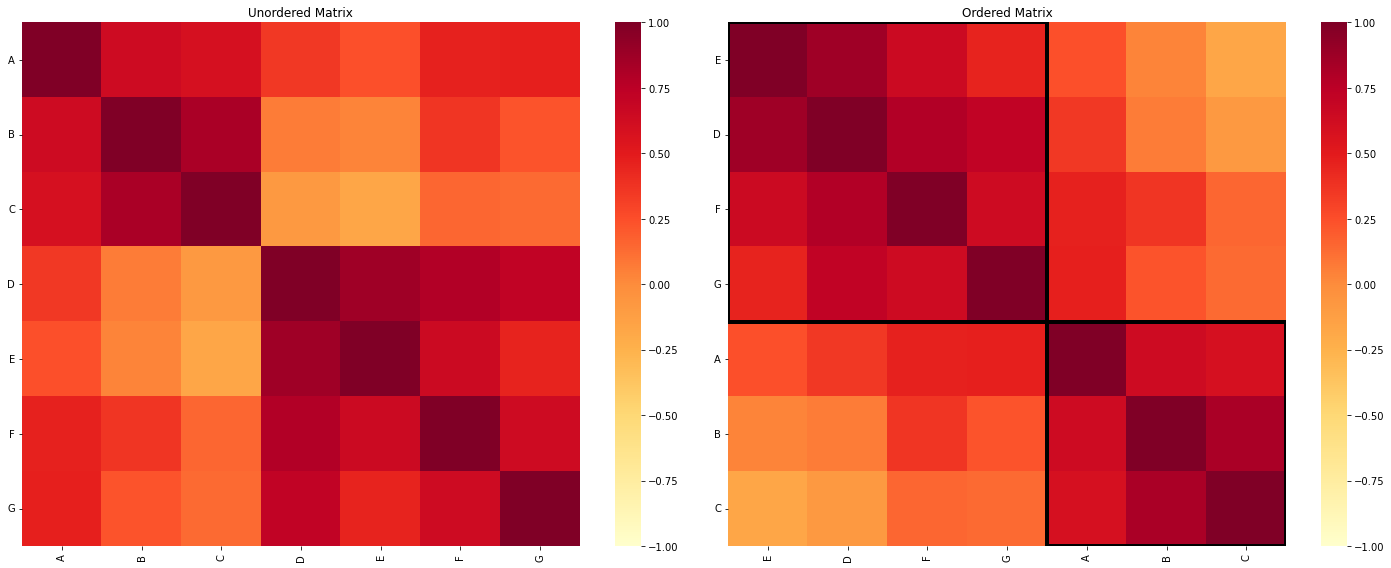

In [ ]:
VisualizeClusters(S1, simMat_rows, row_labels,kernelOrder_rows, partition_rows, save= True, filename= 'rows.png')

## Clusters: Columns
Let's do the same for columns

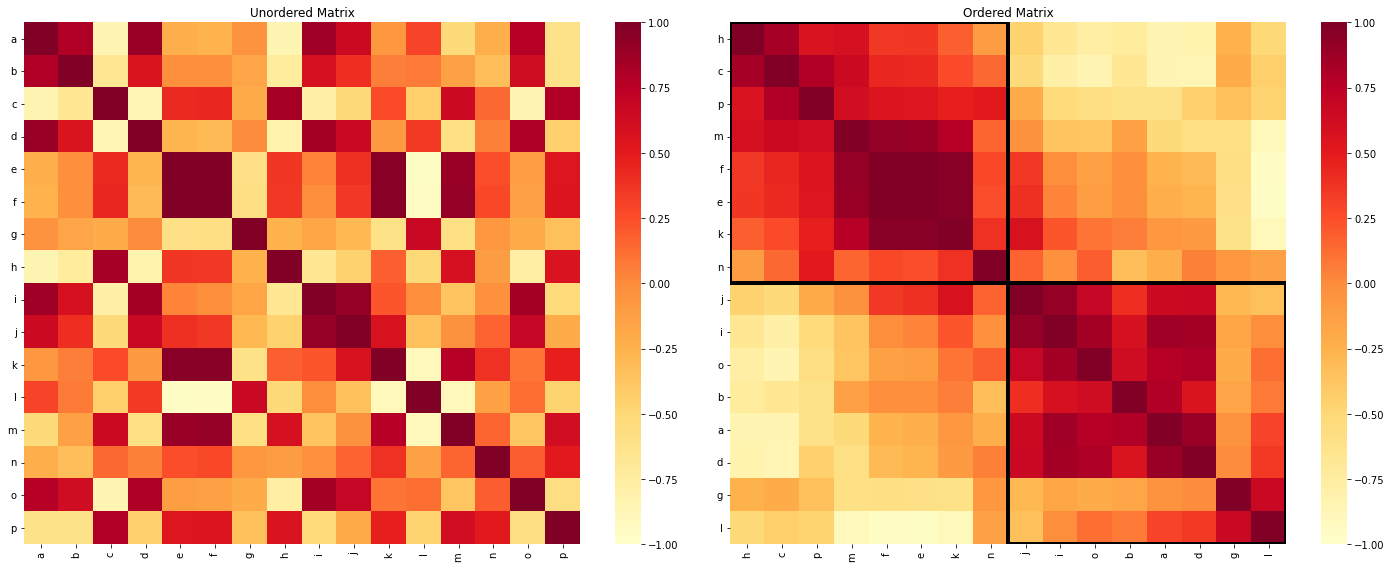

In [ ]:
VisualizeClusters(S2, simMat_cols, col_labels,kernelOrder_cols, partition_cols, save= True, filename= 'cols.png')

## Clusters within the Z-score matrix
Finally, we culminate our analysis by visualizing the reordered and clustered Z-score matrix

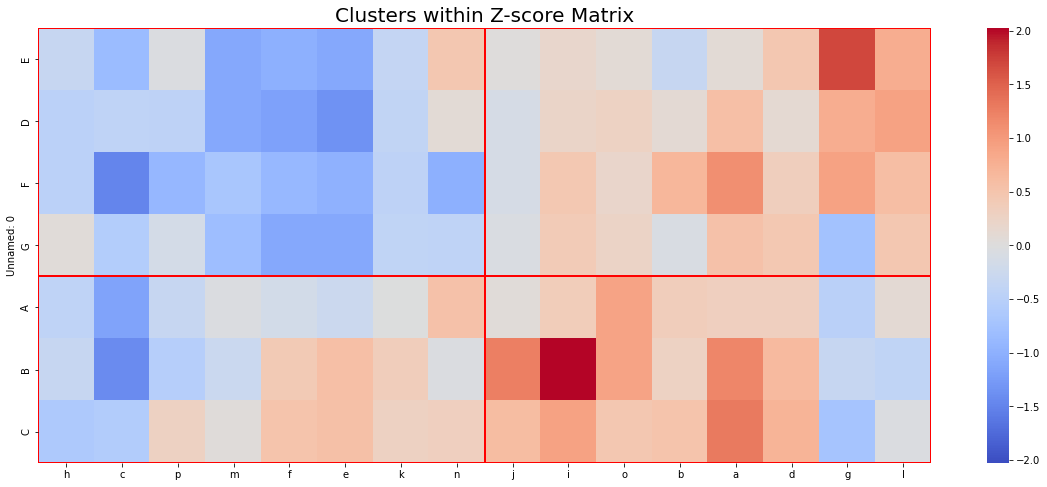

In [ ]:
VisualizeZscoreMatrix(zscores, col_labels, row_labels, kernelOrder_rows, kernelOrder_cols,partition_rows, partition_cols)